## EfnBoost for Survival Analysis

### Introduction
EfnBoost is a method of survival analysis that predicts hazard ratio of coxph using `xgboost` by optimizing the loss function of *Efron Approximation*.

Here we show you how to use EfnBoost model to predict hazard ratio from scratch with the help of `libsurv`.

### Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

And it may help a lot if you know a little of the Efron Approximation.

### Get it started

#### Load datasets

We provide `WHAS` and `METABRIC` datasets for further studies. It can be found in module `libsurv.datasets`.

In [1]:
from libsurv.datasets import load_whas_train
from libsurv.datasets import load_whas_test

data_train = load_whas_train()
data_test = load_whas_test()

In [2]:
print(data_train.columns)

Index(['age', 'gender', 'bmi', 'chf', 'miord', 'e', 't'], dtype='object')


#### Statistics of datasets
Print statistics of survival data. The function `survival_stats` in `libsurv.datasets` provides the tool.

--------------- Survival Data Statistics ---------------
# Rows: 1310
# Columns: 5 + e + t
# Events Ratio: 42.14%
# Min Time: 1
# Max Time: 67



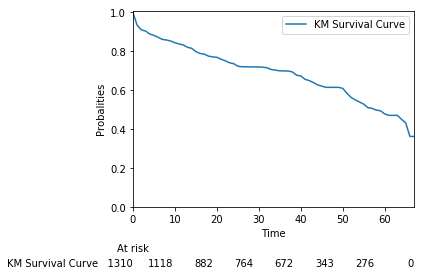

In [3]:
from libsurv.datasets import survival_stats

survival_stats(data_train, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 328
# Columns: 5 + e + t
# Events Ratio: 42.07%
# Min Time: 1
# Max Time: 67



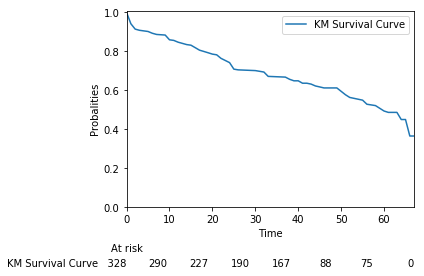

In [4]:
survival_stats(data_test, t_col="t", e_col="e", plot=True)

#### Survival data transfrom

The column of time and status in survival data will be packed into an new column as label in the transformed data.

The transformed survival data contains an new label, where negtive values are considered as right censored, and positive values are considered as event occurrence.

**NOTE**: In `libsurv`, survival data must be transformed via `tfdeepsurv.datasets.survival_df`. But for `xgboost` model, the type of data must be `DMatrix`, so we **have two ways to achive this as listed below**.

```python
##############################################################################
# method 1:
from libsurv.datasets import survival_dmat

surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

##############################################################################

##############################################################################
# method 2
from libsurv.datasets import survival_df
from xgboost import DMatrix


data_train = survival_df(data_train, t_col="t", e_col="e", label_col="Y")
data_test = survival_df(data_test, t_col="t", e_col="e", label_col="Y")

x_cols = list(data_train.columns)[:-1]

surv_train = DMatrix(data_train[x_cols], label=data_train['Y'].values)
surv_test = DMatrix(data_test[x_cols], label=data_test['Y'].values)
################################################################################
```

In [5]:
from libsurv.datasets import survival_dmat

# via survival_dmat function
surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

#### Model initialization

Here we start to initialize a EfnBoost model.

**NOTE**: `num_class` in `model_params` is equals to **K + 1**, where **K denotes the maximum observed time** in your survival data.

In [6]:
from libsurv import EfnBoost

params = {
    'eta':0.3,
    'max_depth':6, 
    'min_child_weight': 8, 
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'gamma': 0.20,
    'lambda': 0,
}

model = EfnBoost(params)

#### Model training

Training model and watch the learning curve.

[0]	train-rmse:41.3548	test-rmse:41.5541	train-efron_loss:6.40707	test-efron_loss:5.04637
[10]	train-rmse:40.8382	test-rmse:41.0603	train-efron_loss:5.81787	test-efron_loss:4.61236
[20]	train-rmse:40.6026	test-rmse:40.8388	train-efron_loss:5.63601	test-efron_loss:4.52832
[30]	train-rmse:40.4514	test-rmse:40.6784	train-efron_loss:5.53066	test-efron_loss:4.44715
[40]	train-rmse:40.3762	test-rmse:40.5953	train-efron_loss:5.45829	test-efron_loss:4.43786
[50]	train-rmse:40.2692	test-rmse:40.5002	train-efron_loss:5.39953	test-efron_loss:4.37979
[60]	train-rmse:40.1823	test-rmse:40.4041	train-efron_loss:5.33884	test-efron_loss:4.3381
[70]	train-rmse:40.1277	test-rmse:40.3542	train-efron_loss:5.28602	test-efron_loss:4.3264
[80]	train-rmse:40.0519	test-rmse:40.271	train-efron_loss:5.22615	test-efron_loss:4.30638
[90]	train-rmse:40.0328	test-rmse:40.2443	train-efron_loss:5.20025	test-efron_loss:4.2888
[99]	train-rmse:40.0182	test-rmse:40.2431	train-efron_loss:5.17733	test-efron_loss:4.28427


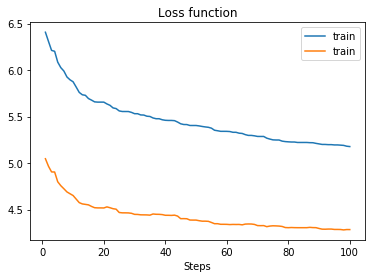

In [7]:
eval_result = model.train(
    surv_train,
    num_rounds=100,
    skip_rounds=10,
    evals=[(surv_train, 'train'), (surv_test, 'test')],
    plot=True
)

#### Prediction and Evaluation

Now we use the trained model to make prediction or evaluate model performance.

Prediction of EfnBoost model via:
- `model.predict`: Hazard Ratio of coxph
- `model.predict_survival_function`: survival function transformed from hazard ratio

Prediction of hazard ratio: [0.0694712  7.574963   0.38022602 0.2501495  7.308943  ]


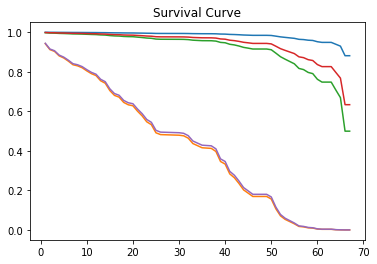

In [9]:
# select the first 5 samples
surv_data_now = surv_test.slice([i for i in range(5)])

# Predict Hazard Ratio
print("Prediction of hazard ratio:", model.predict(surv_data_now, output_margin=False))

# Predict Survival Function
result_survf = model.predict_survival_function(surv_data_now, plot=True)

In [10]:
result_survf

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0
0,0.999449,0.999152,0.999062,0.998829,0.998717,0.998546,0.998349,0.998288,0.998180,0.998002,...,0.959234,0.957893,0.951494,0.948184,0.948184,0.948184,0.938714,0.929152,8.808165e-01,8.808165e-01
1,0.941627,0.911646,0.902757,0.880069,0.869350,0.853320,0.835093,0.829564,0.819855,0.804103,...,0.010693,0.009180,0.004420,0.003023,0.003023,0.003023,0.001012,0.000331,9.782502e-07,9.782502e-07
2,0.996986,0.995368,0.994878,0.993608,0.992997,0.992070,0.990995,0.990665,0.990079,0.989116,...,0.796289,0.790215,0.761752,0.747362,0.747362,0.747362,0.707408,0.668859,4.992868e-01,4.992868e-01
3,0.998016,0.996950,0.996627,0.995790,0.995387,0.994776,0.994066,0.993848,0.993462,0.992826,...,0.860825,0.856499,0.836076,0.825651,0.825651,0.825651,0.796340,0.767518,6.332066e-01,6.332066e-01
4,0.943618,0.914612,0.906006,0.884026,0.873635,0.858087,0.840395,0.835025,0.825594,0.810283,...,0.012541,0.010824,0.005347,0.003706,0.003706,0.003706,0.001289,0.000439,1.590360e-06,1.590360e-06


In [11]:
# evaluate model performance 
print("td-CI on training set:", model.evals(surv_train))
print("td-CI on test set:", model.evals(surv_test))

td-CI on training set: 0.9256697500240054
td-CI on test set: 0.856783834267278


#### save model

In [12]:
model.save_model("EfnBoost.model")